In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions


import pandas as pd
import numpy as np

from linux_qm.src.render import indigo, draw_reacting_mapnums
from linux_qm.src.util import load_smiles3D
from linux_qm.qm.orca.orca import OrcaDriver

In [3]:
df = pd.read_csv('../data/slv_amides/amide_training_set.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rxn_id            15999 non-null  int64  
 1   acid_smi          15999 non-null  object 
 2   amine_smi         15999 non-null  object 
 3   product_smi       15999 non-null  object 
 4   activators_names  9719 non-null   object 
 5   yield             15999 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 750.1+ KB


In [4]:
df['rxn_smi'] = df.amine_smi + '.' + df.acid_smi + '>>' + df.product_smi
df.rxn_smi

0        N[C@@H](CCCCNC(=O)C(F)(F)F)C(=O)O.OC(CCCCCCCCC...
1        NCC(=O)NCC(=O)NCC(=O)O.OC(CSC(C)=O)=O>>[CH3:1]...
2        NCCN.OC(=O)CCN(CCNC(=O)CCN(CCOCCOCCOCC1OCCO1)C...
3        NCCN.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH:3]([O:19]...
4        NCc1cccc(CN)c1.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH...
                               ...                        
15994    CCO[Si](CCCN)(OCC)OCC.OC(=O)CC=O>>[CH3:1][CH2:...
15995    NCCC(=O)O.OC(C(=C)C)=O>>[CH2:1]=[C:2]([C:4]([N...
15996    N1CCOCC1.OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]...
15997    CC[C@H](C)N.OC(=O)c1cc(Cl)cc(F)[n]1>>[CH3:1][C...
15998    NCc1ccccc1.OC(=O)c1[n]cc[n][n]1>>[O:1]=[C:2]([...
Name: rxn_smi, Length: 15999, dtype: object

[NH2:1][c:2]1[cH:8]cc(O)[cH:4][cH:3]1.[CH3:9][C:10](=O)[OH:11]>>CC(=O)[NH:1][c:2]1[cH:3][cH:4][c:10]([OH:11])[cH:9][cH:8]1
Reacting Atom Idx: ((0, 2, 3, 4, 5, 6), (0, 1, 2))
Mapped reacting atom: N 1
Mapped reacting atom: C 8
Mapped reacting atom: C 0
Mapped reacting atom: C 0
Mapped reacting atom: O 0
Mapped reacting atom: C 4
Mapped reacting atom: C 9
Mapped reacting atom: C 10
Mapped reacting atom: O 0


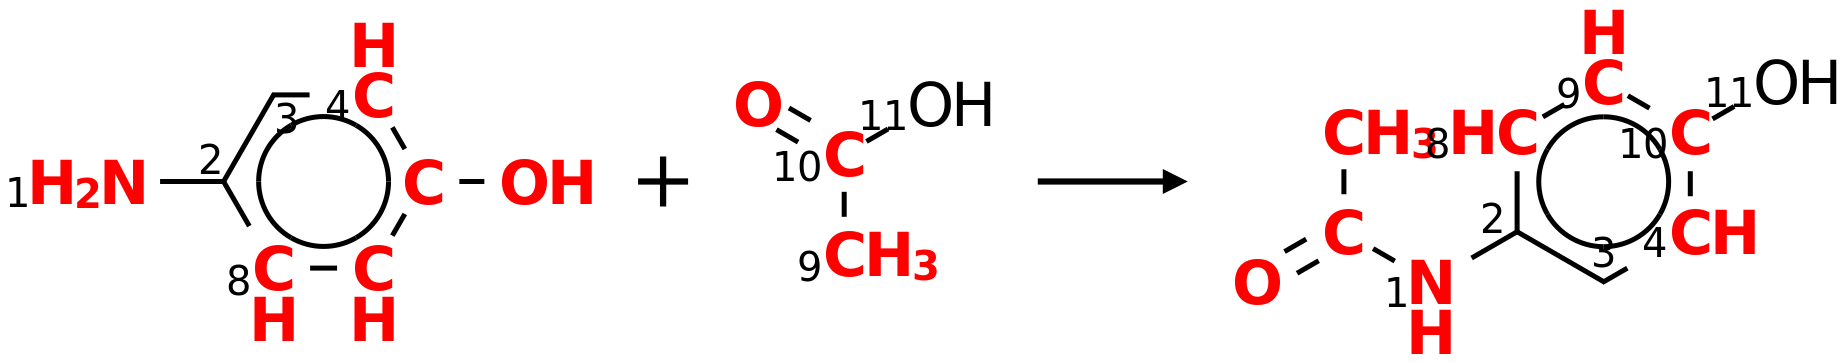

[1, 8, 0, 0, 0, 4, 9, 10, 0]

In [5]:
# rxn_smi = df.rxn_smi.sample(1).iat[0]
rxn_smi = "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc2ccc(O)cc2)=O"

ind_rxn = indigo.loadReaction(rxn_smi)
ind_rxn.automap("discard")
rxn_smi = ind_rxn.smiles()

print(rxn_smi)

draw_reacting_mapnums(rxn_smi)

In [6]:
import re

re.sub(r':\d+','',  rxn_smi)

'[NH2][c]1[cH]cc(O)[cH][cH]1.[CH3][C](=O)[OH]>>CC(=O)[NH][c]1[cH][cH][c]([OH])[cH][cH]1'

In [7]:
from rxnmapper import BatchedMapper
rxn_mapper = BatchedMapper(batch_size=16)

def rxn_map(rxn_smi):
    clear_smi = re.sub(r':\d+','',  rxn_smi)
    mapped_rxn = list(rxn_mapper.map_reactions([clear_smi]))[0]
    return mapped_rxn

Reacting Atom Idx: ((0,), (1, 3))
Mapped reacting atom: N 4
Mapped reacting atom: C 2
Mapped reacting atom: O 0


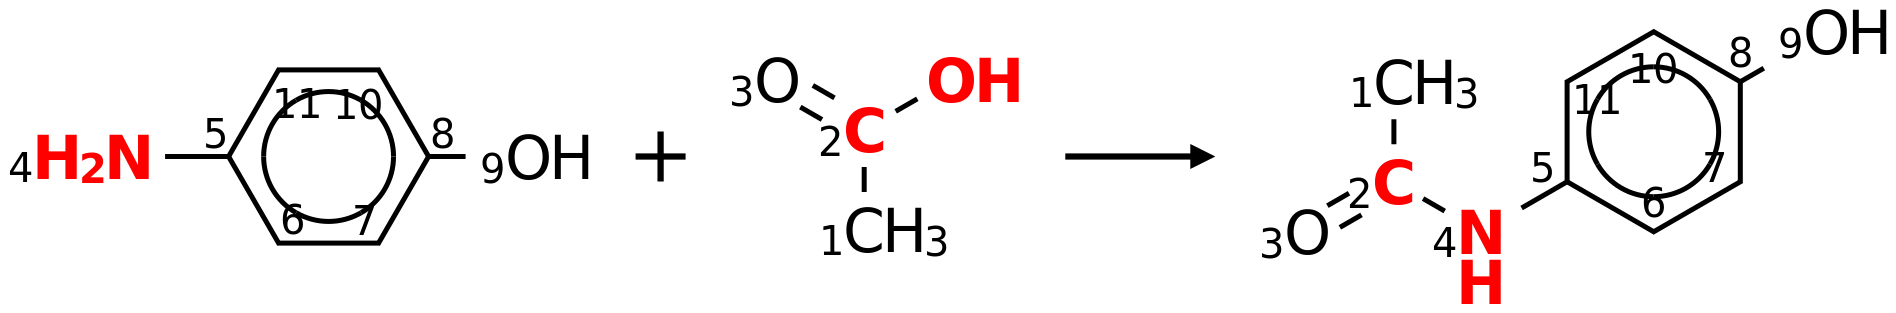

[4, 2, 0]

In [8]:
draw_reacting_mapnums(rxn_map(rxn_smi))

In [11]:
def automap_rxn(rxn_smi):
    ind_rxn = indigo.loadReaction(rxn_smi)
    ind_rxn.automap("discard")
    return ind_rxn.smiles()


def get_amine_atoms(mol, reacting_nitrogen_idx: int):
    amine_aids = [reacting_nitrogen_idx]
    atom = mol.GetAtomWithIdx(reacting_nitrogen_idx)
    for a in atom.GetNeighbors():
        if a.GetSymbol() == 'C':
            amine_aids.append(a.GetIdx())
    return amine_aids


def orca_calculation(conf):
    orca = OrcaDriver()

    orca.options['n_jobs'] = 1

    orca.options['method'] = 'XTB2'
    orca.geometry_optimization(conf)

    orca.options['method'] = 'HF-3c'
    # orca.options['method'] = 'BP86 def2-SVP def2/J D3BJ RIJCOSX'
    data = orca.single_point(conf)

    # data = orca.geometry_optimization(conf)
    return data

def gen_amine_electronic(rxn_smi):
    # rxn_smi = automap_rxn(rxn_smi)
    rxn_smi = rxn_map(rxn_smi)

    # load rxn
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get amine mol
    amine, _ = rxn.GetReactants()
    mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)

    # qm calculation
    data = orca_calculation(mol.GetConformer())

    # parse output
    amine_raids = get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])
    charges = np.hstack([data.atomcharges['mulliken'][amine_raids], data.atomcharges['lowdin'][amine_raids]])
    print(charges)
    return charges

In [13]:
mol = load_smiles3D("NCC", opt=True)

# qm calculation
data = orca_calculation(mol.GetConformer())

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N           -1.42324760          0.17828561          0.22135572
C           -0.15697983          0.53694713         -0.40530679
C            0.96441261         -0.37551544          0.06159949
H           -1.64665973         -0.79330981          0.00814844
H           -1.32810559          0.22609049          1.23527380
H            0.08369993          1.57684404         -0.16178040
H           -0.26189243          0.47089607         -1.49307873
H            1.10501699         -0.30820416          1.14564470
H            1.90627562         -0.09165663         -0.41870827
H            0.75748003         -1.42037728         -0.19314796
*


DEBUG:root:ORCA OUTPUT:

                                *** OPTIMIZATION RUN DONE ***

Timings for individual modules:

Sum of individual times         ...        0.122 sec (=   0.002 min)
Geometry relaxation             ...        0.059 sec (=   0.001

IndexError: list index out of range

In [12]:
gen_amine_electronic("Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O")

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N            2.32558818          0.15625863         -0.15892652
C            0.92914628          0.08279975         -0.12171522
C            0.18284491          1.14499980          0.40076991
C           -1.20123001          1.03464414          0.55367915
C           -1.83216684         -0.15709773          0.22236378
F           -3.15850274         -0.26709547          0.37268056
C           -1.10264924         -1.24298918         -0.24319438
C            0.28119075         -1.12721128         -0.39420700
H            2.75622520         -0.49032709         -0.81254384
H            2.68740036          1.09985313         -0.25618854
H            0.67504176          2.06859474          0.69347931
H           -1.78420096          1.86318664          0.94167620
H           -1.60943204         -2.17472216         -0.47106273
H            0.85074439         -1.99089393         -0.72681068
*

IndexError: list index out of range

In [10]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

reactions = [
    # "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(Si)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    "Nc1ccc(NC)cc1.CC(O)=O>>CC(Nc1ccc(NC)cc1)=O",
    "Nc1ccc(N(C)C)cc1.CC(O)=O>>CC(Nc1ccc(N(C)C)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O",
    # "Nc1ccc(Br)cc1.CC(O)=O>>CC(Nc1ccc(Br)cc1)=O",
    # "Nc1ccc(I)cc1.CC(O)=O>>CC(Nc1ccc(I)cc1)=O",
]

# labels = ['C', 'N', 'O', 'F']
labels = ['NH2', 'NHMe', 'NMe2']
# labels = ['C', 'NH2' ,'OH', 'F', 'Cl', 'Br', 'I']
amine_descr = np.empty((0, 4))
for rxn_smi in reactions:
    d = gen_amine_electronic(rxn_smi)
    amine_descr = np.vstack([amine_descr, d])
res = pd.DataFrame(amine_descr, columns=['mul_N', 'mul_C', 'lod_N', 'lod_C'], index=labels)
res

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N            2.72708249         -0.14296682         -0.66019076
C            1.38013372         -0.02189461         -0.30089326
C            0.88055436         -0.71067428          0.80466170
C           -0.48685040         -0.68802164          1.10341184
C           -1.37983711          0.02382748          0.30210393
N           -2.75701639         -0.05211672          0.53797217
C           -0.89603827          0.60976559         -0.86788079
C            0.47136662          0.58711263         -1.16663081
H            3.34634196         -0.30858781          0.12672011
H            3.05828799          0.60501112         -1.26100050
H            1.54873441         -1.28457073          1.44052894
H           -0.84683695         -1.24488564          1.96391234
H           -3.28473376          0.71009103          0.12482035
H           -2.99668088         -0.20350824          1.51253994
H

IndexError: list index out of range

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

res.iloc[:] = scaler.fit_transform(res)
res

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    res
)

In [ ]:
rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
rxn.Initialize()

amine, acid = rxn.GetReactants()
rxn.GetReactingAtoms()

In [ ]:
mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [ ]:
%%time

# Calculate ORCA descriptors
from linux_qm.qm.orca.orca import OrcaDriver

orca = OrcaDriver(options={'method': 'HF-3c'})

data = orca.single_point(mol.GetConformer())

In [ ]:
def get_amine_atoms(mol, reacting_nitrogen_idx: int):
    amine_aids = [reacting_nitrogen_idx]
    atom = mol.GetAtomWithIdx(reacting_nitrogen_idx)
    for a in atom.GetNeighbors():
        if a.GetSymbol() == 'C':
            amine_aids.append(a.GetIdx())
    return amine_aids
    # atom

amine_raids = get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])
np.array(data.metadata['coords'])[amine_raids]

In [ ]:
charges = data.atomcharges['mulliken'][amine_raids]
charges.shape

In [ ]:
charges = np.hstack([charges, data.atomcharges['lowdin'][amine_raids]])

In [ ]:
homo = data.moenergies[0][data.homos[0]]
lumo = data.moenergies[0][data.homos[0] + 1]
homo, lumo

In [ ]:
dir(data)

In [ ]:
for ridx, reacting in enumerate(rxn.GetReactingAtoms()):
    reactant = rxn.GetReactantTemplate(ridx)
    print(Chem.MolToSmiles(reactant))
    for raidx in reacting:
        atom = reactant.GetAtomWithIdx(raidx)
        mapnum = atom.GetAtomMapNum()
        print('Mapped reacting atom:', atom.GetSymbol(), mapnum)
        # print(Chem.MolToSmiles(reactant))